In [1]:
import matplotlib.pyplot as plt
import time
import numpy as np
from pkg.utils import *
import rospy

In [2]:
gtimer = GlobalTimer.instance()
TRAJECTORY_FREQ = 50
rospy.init_node('indy_test', anonymous=True)
rate = rospy.Rate(TRAJECTORY_FREQ*4)

# Prepare indy

In [3]:
from pkg.indy_repeater import *

In [4]:
robot_ip = "192.168.0.63"  # Robot (Indy) IP
robot_name = "NRMK-Indy7"  # Robot name (Indy7)
# robot_name = "NRMK-IndyRP2"  # Robot name (IndyRP2)

# Create class object
indy = client.IndyDCPClient(robot_ip, robot_name)

indy.connect()
indy.set_collision_level(5)
indy.set_joint_vel_level(3)
indy.set_task_vel_level(3)
indy.set_joint_blend_radius(20)
indy.set_task_blend_radius(0.2)

print(indy.get_collision_level())
print(indy.get_joint_vel_level())
print(indy.get_task_vel_level())
print(indy.get_joint_blend_radius())
print(indy.get_task_blend_radius())


indy.stop_motion()

indy.disconnect()

Connect: Server IP (192.168.0.63)
5
3
3
20.0
0.2


# Test indy tracking

[ 0. -0. -0.  0. -0.  0.]
[ 0. -0. -0.  0. -0.  0.]
[0. 0. 0. 0. 0. 0.]


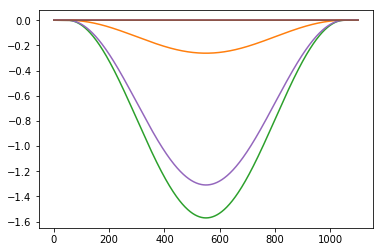

In [5]:
# Prepare path

N_t = 1000
MAG = 1#np.deg2rad(5)
e_POS = np.deg2rad([[0, -15, -90, 0, -75, 0]])*np.transpose([MAG*((np.sin(np.pi*(np.arange(N_t+1)*2-N_t/2)/N_t)+1)/2)])
e_POS = np.pad(e_POS, [[50,50],[0,0]],'edge')
plt.plot(e_POS)
print(e_POS[0])
print(e_POS[-1])
print(e_POS[0]-e_POS[-1])

In [6]:
# test init stop
indy_joint_move_make_sure(indy, e_POS[0], connect=True)
indy_init_online_tracking(indy, e_POS[0], traj_freq=TRAJECTORY_FREQ)

Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)


{'step_c': 80}

In [7]:
indy_stop_online_tracking(indy)

Connect: Server IP (192.168.0.63)


In [12]:
gtimer.reset()
# test init stop
indy_joint_move_make_sure(indy, e_POS[0], connect=True)
indy_init_online_tracking(indy, e_POS[0], traj_freq=TRAJECTORY_FREQ)

time.sleep(0.5)

qcount = 0
qcount_indy_list = []
looptime_list = []
networktime_list = []

i_q = 0
while i_q <len(e_POS):
    Q = e_POS[i_q]
    gtimer.tic("loop")
    Q_indy = Q#[0]*6
#     while(qcount>=3):
#         qcount -= 1
#         rate.sleep()
    if qcount>=3:
        rate.sleep()
    if qcount>3:
        gtimer.tic("send_recv_qc")
        qcount_indy = indy_get_qcount(indy)
        networktime_list.append(gtimer.toc("send_recv_qc"))
    else:
        gtimer.tic("send_recv_qv")
        qcount_indy=indy_send_track_q(indy, Q_indy)['qcount']
        networktime_list.append(gtimer.toc("send_recv_qv"))
        i_q += 1
    qcount = qcount_indy
    qcount_indy_list.append(qcount_indy)
    looptime_list.append(gtimer.toc("loop"))
    
indy_stop_online_tracking(indy)

Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)


loop: 	21864.0 ms/4392 = 4.978 ms (1.085/5.7)
send_recv_qv: 	1851.0 ms/1101 = 1.681 ms (1.064/2.034)
send_recv_qc: 	4925.0 ms/3291 = 1.496 ms (1.107/1.691)



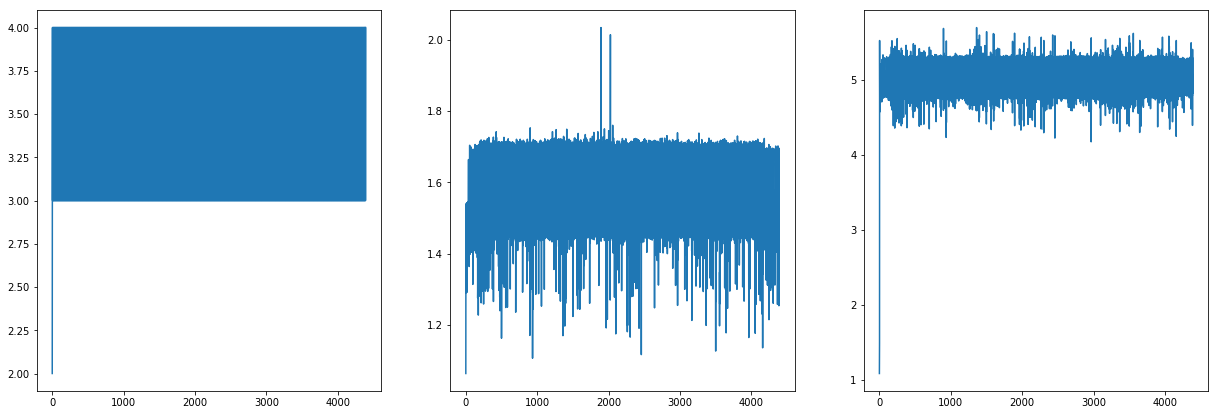

In [13]:
plt.figure(figsize=(21,7))
plt.subplot(1,3,1)
ax = plt.plot(qcount_indy_list[1:])
plt.subplot(1,3,2)
ax = plt.plot(networktime_list[1:])
plt.subplot(1,3,3)
ax = plt.plot(looptime_list[1:])
print(gtimer)

# Prepare panda

In [3]:
from pkg.panda_repeater import *
PANDA_DOF = 7
panda = PandaRepeater(traj_freq=TRAJECTORY_FREQ)

# Test panda

[ 0.35907322  0.01795209 -0.48812518 -1.76649034 -0.05815828  2.32447815
 -2.54106927]
[ 0.35907322  0.01795209 -0.48812518 -1.76649034 -0.05815828  2.32447815
 -2.54106927]
[0. 0. 0. 0. 0. 0. 0.]


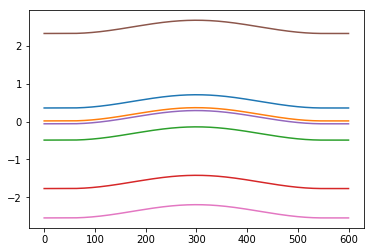

In [4]:
# Prepare path
Q0_panda = panda.get_qcur()

N_t = 500
N_rep = 1
MAG = 2#np.deg2rad(5)
e_POS = np.deg2rad([[10]*PANDA_DOF])*np.transpose([MAG*((np.sin(np.pi*(np.arange(N_t*N_rep+1)*2-N_t/2)/N_t)+1)/2)])
e_POS = Q0_panda+np.pad(e_POS, [[50,50],[0,0]],'edge')
plt.plot(e_POS)
print(e_POS[0])
print(e_POS[-1])
print(e_POS[0]-e_POS[-1])

In [5]:
gtimer.reset()
panda.reset()
time.sleep(0.1)
qcount_panda_list = []
looptime_list = []
networktime_list = []
qcount = 0 
i_q = 0
while i_q <len(e_POS):
    Q = e_POS[i_q]
    gtimer.tic("loop")
    Q_panda = Q
    #while(qcount>=3):
    #    qcount -= 1
    #    rate.sleep()
    if qcount>=3:
        rate.sleep()
    gtimer.tic("send_recv")
    if qcount>3:
        qcount_panda = panda.get_qcount()
    else:
        qcount_panda = panda.send_qval(Q_panda)['qcount']
        i_q+=1
    networktime_list.append(gtimer.toc("send_recv"))
    qcount = qcount_panda
    qcount_panda_list.append(qcount_panda)
    looptime_list.append(gtimer.toc("loop"))
panda.stop_tracking()

{'stop': True}

loop: 	11947.0 ms/1199 = 9.964 ms (0.81/10.581)
send_recv: 	1324.0 ms/1199 = 1.104 ms (0.637/1.655)



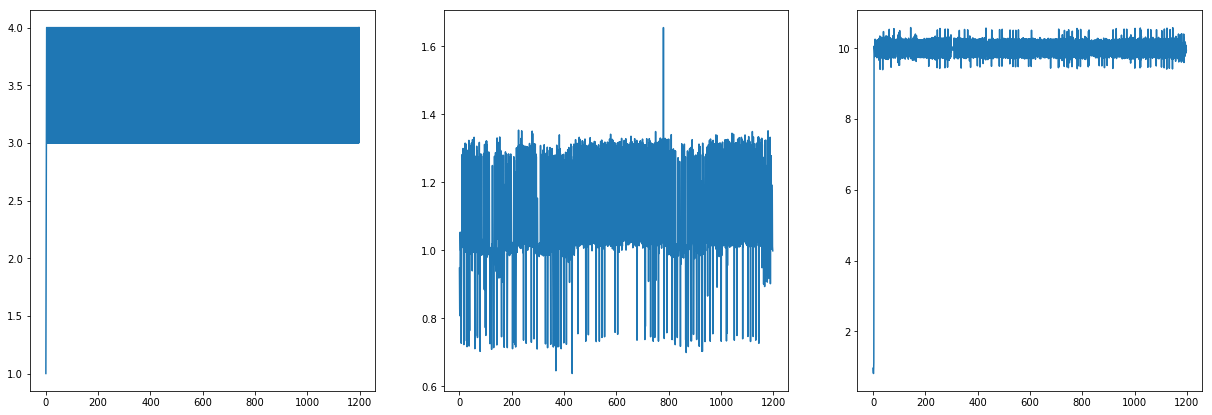

In [6]:
plt.figure(figsize=(21,7))
plt.subplot(1,3,1)
ax = plt.plot(qcount_panda_list)
plt.subplot(1,3,2)
ax = plt.plot(networktime_list)
plt.subplot(1,3,3)
ax = plt.plot(looptime_list)
print(gtimer)

In [307]:
# send_recv({'terminate': True}, panda.host, panda.port)

{'terminate': True}

In [13]:
dat = np.loadtxt("/home/junsu/Downloads/test.txt")

In [14]:
dat.shape

(46185, 20)

In [15]:
count_list = []
for i in range(len(dat)/10):
    count_list.append(np.sum(dat[:,0]==i))

[0, 10000, 70, 90]

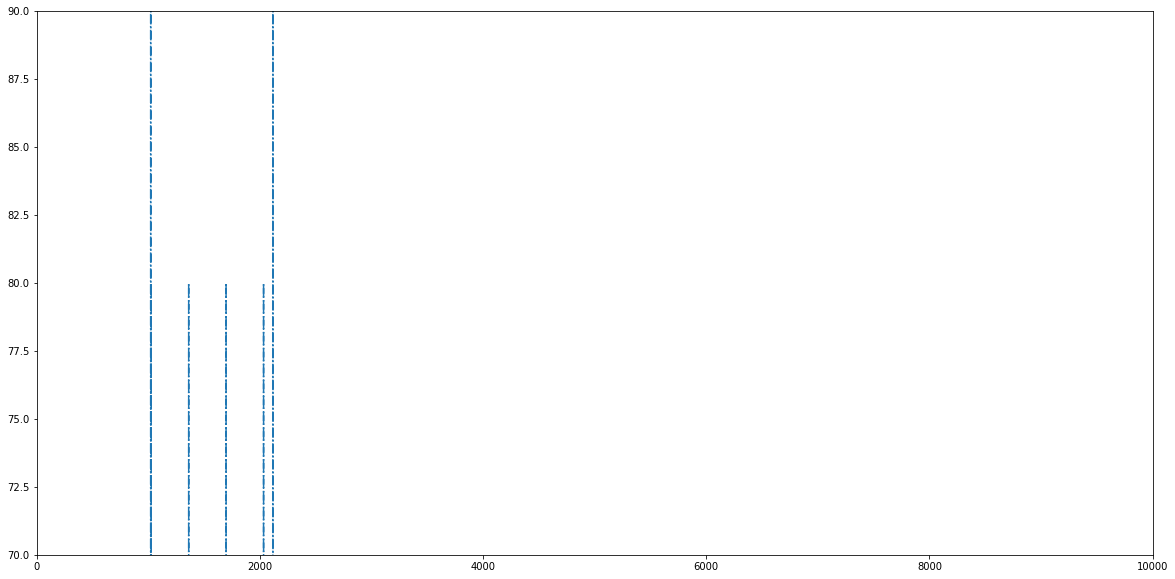

In [16]:
plt.figure(figsize=(20,10))
plt.plot(count_list,'-.')
plt.axis([0,10000,70,90])

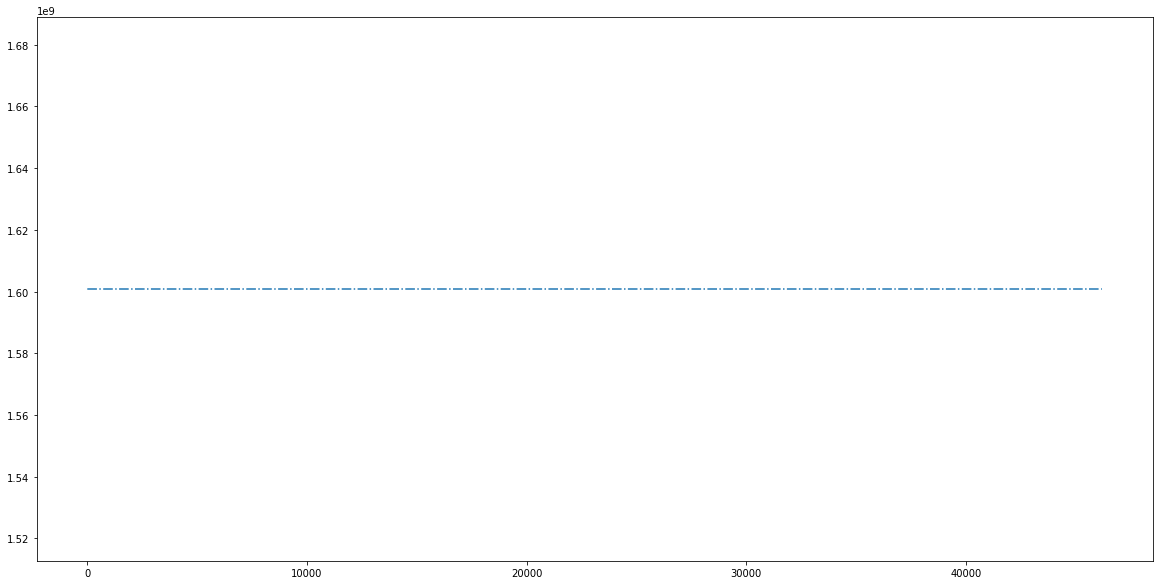

In [23]:
plt.figure(figsize=(20,10))
plt.plot(dat[:,1], '-.')
# plt.plot(dat[:,1]-dat[0,1]-np.arange(len(dat))*31,'-.')
# plt.axis([0,1200,0,50])

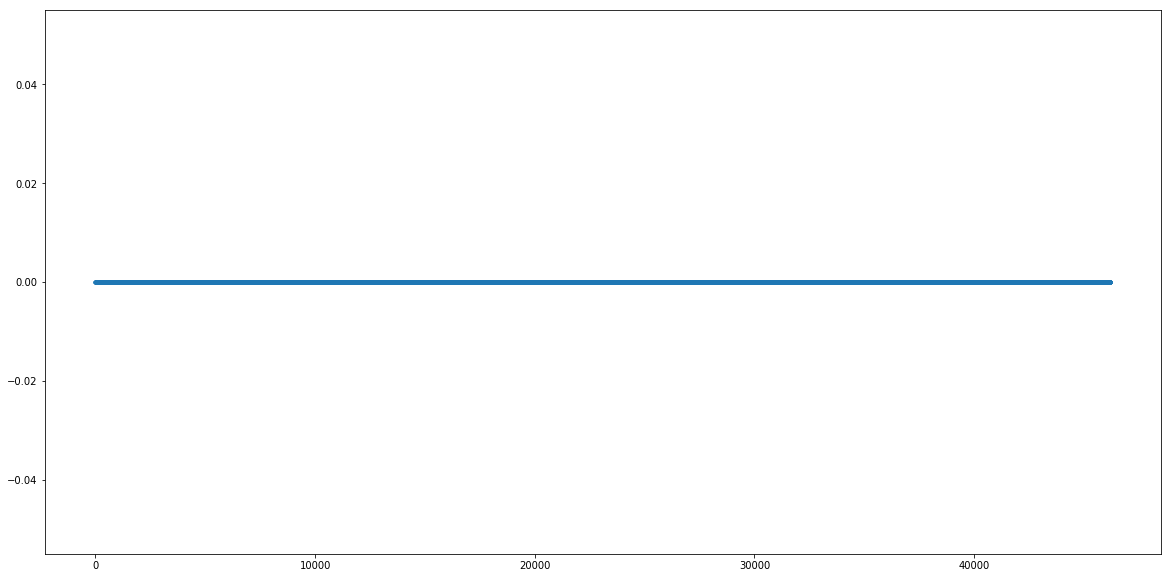

In [18]:
plt.figure(figsize=(20,10))
plt.plot(dat[1:,1]-dat[:-1,1], '.')
# plt.plot(dat[:,1]-dat[0,1]-np.arange(len(dat))*31,'-.')
# plt.axis([0,1200,0,50])

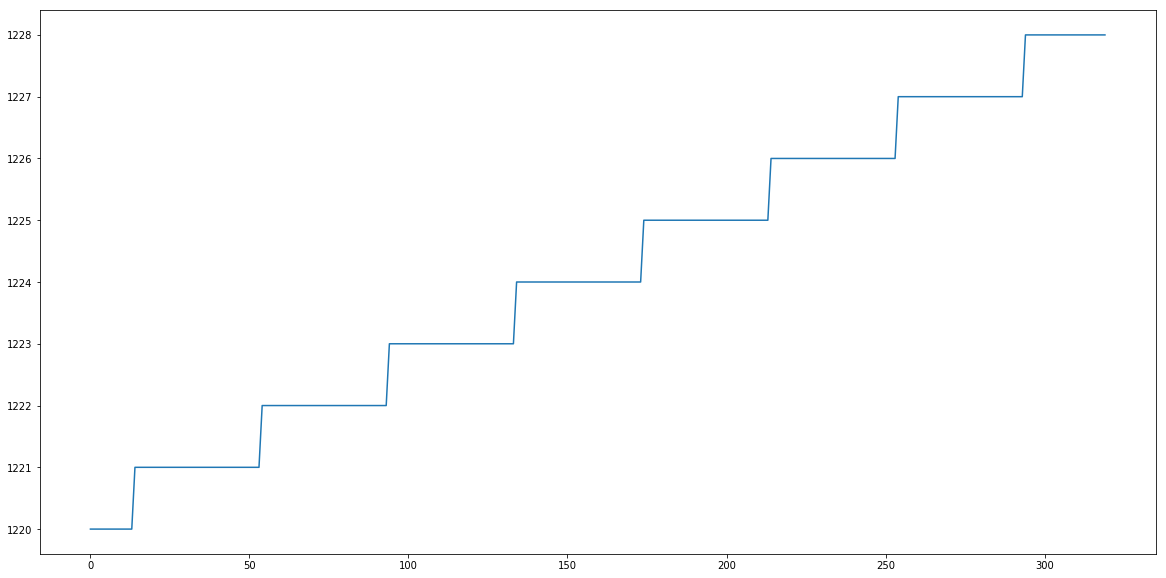

In [19]:
plt.figure(figsize=(20,10))
ax = plt.plot(dat[10000:10320,0])

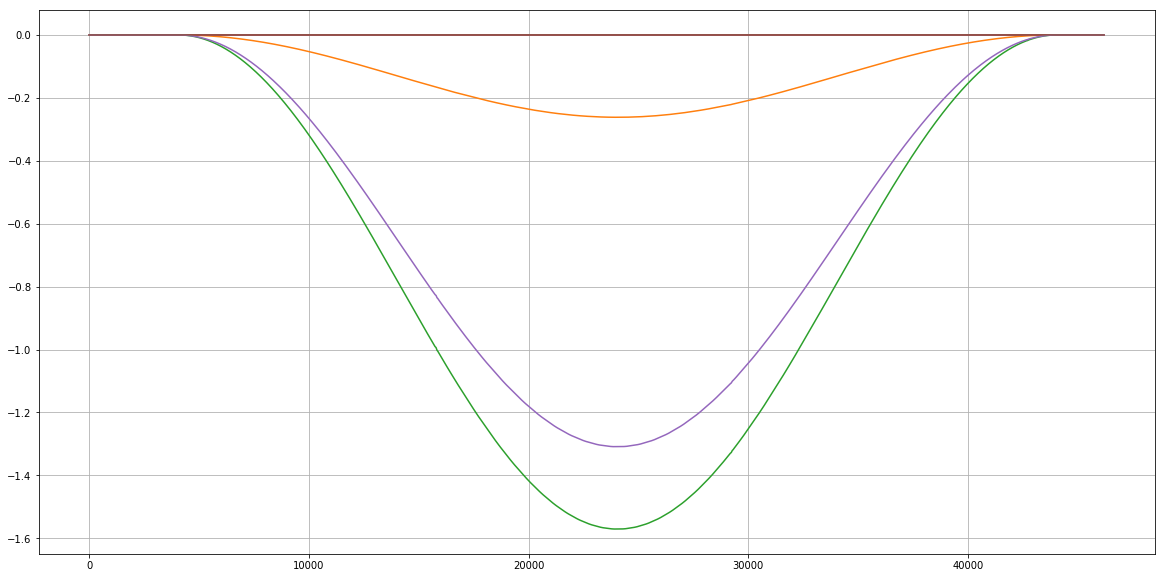

In [20]:
plt.figure(figsize=(20,10))
ax = plt.plot(dat[:,2:8])
plt.grid()

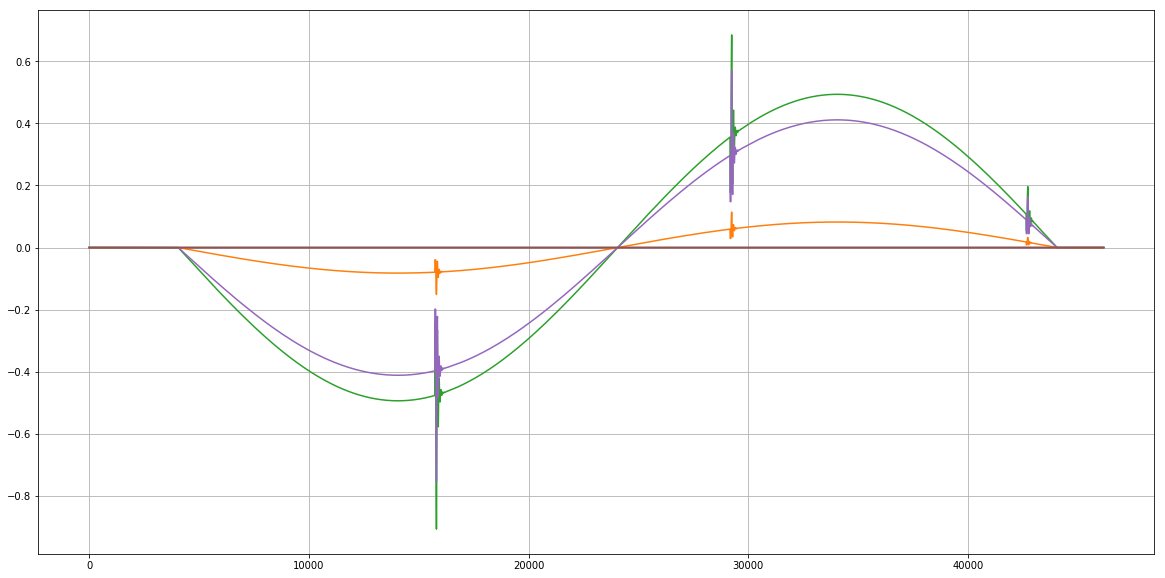

In [21]:
plt.figure(figsize=(20,10))
ax = plt.plot(dat[:,8:14])
plt.grid()

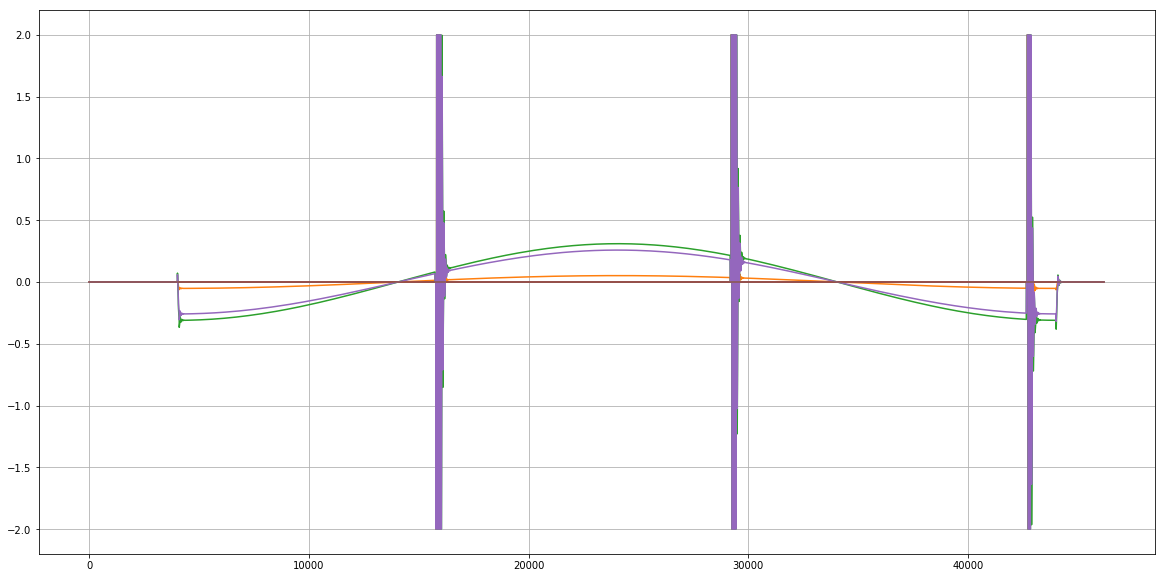

In [22]:
plt.figure(figsize=(20,10))
ax = plt.plot(dat[:,14:20])
plt.grid()

# Test both

In [43]:
Q0_panda = panda.get_qcur()

[ 0.         -0.         -0.          0.         -0.          0.
  0.35895073  0.01779152 -0.48814395 -1.76630592 -0.05859379  2.32404065
 -2.54168296]
[ 0.         -0.         -0.          0.         -0.          0.
  0.35895073  0.01779152 -0.48814395 -1.76630592 -0.05859379  2.32404065
 -2.54168296]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


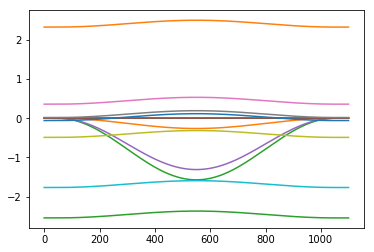

In [44]:
# Prepare path

N_t = 1000
PORT_REPEATER = 1189
indy_idx = np.arange(6)
panda_idx = np.arange(7)+6

MAG = 1#np.deg2rad(5)
e_POS_indy = np.deg2rad([[0, -15, -90, 0, -75, 0]])*np.transpose([MAG*((np.sin(np.pi*(np.arange(N_t+1)*2-N_t/2)/N_t)+1)/2)])
e_POS_indy = np.pad(e_POS_indy, [[50,50],[0,0]],'edge')
e_POS_panda = np.deg2rad([[10]*PANDA_DOF])*np.transpose([MAG*((np.sin(np.pi*(np.arange(N_t+1)*2-N_t/2)/N_t)+1)/2)])
e_POS_panda = Q0_panda+np.pad(e_POS_panda, [[50,50],[0,0]],'edge')
e_POS = np.concatenate([e_POS_indy, e_POS_panda], axis=1)

plt.plot(e_POS)
print(e_POS[0])
print(e_POS[-1])
print(e_POS[0]-e_POS[-1])

In [48]:
gtimer.reset()

indy.connect()
indy_joint_move_make_sure(indy, e_POS[0, indy_idx])
indy_init_online_tracking(indy, e_POS[0, indy_idx], TRAJECTORY_FREQ)
panda.reset()

qcount = 0
qcount_indy_list = []
qcount_panda_list = []
looptime_list = []
networktime_indy_list = []
networktime_panda_list = []
for i_q in range(len(e_POS)):
    Q = e_POS[i_q]
    gtimer.tic("loop")
    Q_indy = Q[indy_idx]#[0]*6
    Q_panda = Q[panda_idx]
    if qcount>=3:
        qcount -= 1
        rate.sleep()
    gtimer.tic("send_recv_indy")
    if qcount_indy>3:
        qcount_indy = indy_get_qcount(indy)
    else:
        qcount_indy=indy_send_track_q(indy, Q_indy)['qcount']    
    ntime_indy = gtimer.toc("send_recv_indy")
    gtimer.tic("send_recv_panda")
    if qcount_panda>3:
        qcount_panda = panda.get_qcount()
    else:
        qcount_panda = panda.send_qval(Q_panda)['qcount']
    ntime_panda = gtimer.toc("send_recv_panda")
    networktime_panda_list.append(ntime_panda)
    networktime_indy_list.append(ntime_indy)
    qcount = qcount_indy
    qcount_indy_list.append(qcount_indy)
    qcount_panda_list.append(qcount_panda)
    looptime_list.append(gtimer.toc("loop"))
    
indy_stop_online_tracking(indy)
panda.stop_tracking()
indy.disconnect()

Connect: Server IP (192.168.0.63)


loop: 	5476.0 ms/1101 = 4.974 ms (2.672/6.3)
send_recv_indy: 	1720.0 ms/1101 = 1.562 ms (0.969/2.077)
send_recv_panda: 	1401.0 ms/1101 = 1.273 ms (0.815/2.27)



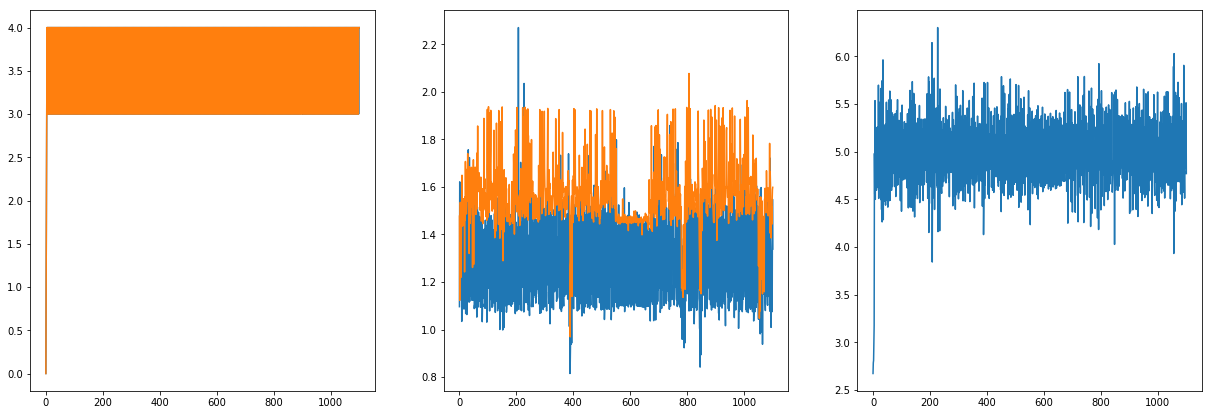

In [46]:
plt.figure(figsize=(21,7))
plt.subplot(1,3,1)
ax = plt.plot(qcount_panda_list)
ax = plt.plot(qcount_indy_list)
plt.subplot(1,3,2)
ax = plt.plot(networktime_panda_list)
ax = plt.plot(networktime_indy_list)
plt.subplot(1,3,3)
ax = plt.plot(looptime_list)
print(gtimer)